In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scienceplots
%matplotlib inline

from nanonets.utils import load_boolean_results, fitness, abundance, nonlinear_parameter, return_ndr, return_nls
from scipy.optimize import curve_fit

data_folderA = "/home/jonasmensing/bagheera/data/1_funding_period/controls/posA/"
data_folderB = "/home/jonasmensing/bagheera/data/1_funding_period/controls/posB/"

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Parameter
N_valsA = [4,6,8,10,12]
N_keysA = len(N_valsA)
N_valsB = [4,6,8,10,12,14]
N_keysB = len(N_valsB)
N_np    = 9

# Boolean On and Off
off_statesA = np.array(N_keysA*[0.0])
off_statesB = np.array(N_keysB*[0.0])
on_statesA  = np.array(N_keysA*[0.01])
on_statesB  = np.array(N_keysB*[0.01])

dataA = load_boolean_results(folder=data_folderA, N=N_np, N_e=N_valsA, input_cols=['E0','E1'], on_state=0.01, max_error=0.1)
dataB = load_boolean_results(folder=data_folderB, N=N_np, N_e=N_valsB, input_cols=['E0','E1'], on_state=0.01, max_error=0.1)

## Fitness Abundance

In [3]:
delta       = 0.0
fitnessA    = {N : fitness(df=dataA[N], input_cols=['E0','E1'], delta=delta) for N in N_valsA}
abundanceA  = {N : abundance(df=fitnessA[N]) for N in N_valsA}

fitnessB    = {N : fitness(df=dataB[N], input_cols=['E0','E1'], delta=delta) for N in N_valsB}
abundanceB  = {N : abundance(df=fitnessB[N]) for N in N_valsB}

In [4]:
fitness_res = pd.DataFrame()

for j, N in enumerate(N_valsA): 

    df          = pd.melt(fitnessA[N].loc[:,'AND Fitness':], var_name='Gate', value_name='Fitness')
    df['key']   = f'A{N-3}'
    fitness_res = pd.concat([fitness_res, df], ignore_index=True)

for j, N in enumerate(N_valsB[::-1]):
    
    df          = pd.melt(fitnessB[N].loc[:,'AND Fitness':], var_name='Gate', value_name='Fitness')
    df['key']   = f'B{N-3}'
    fitness_res = pd.concat([fitness_res, df], ignore_index=True)

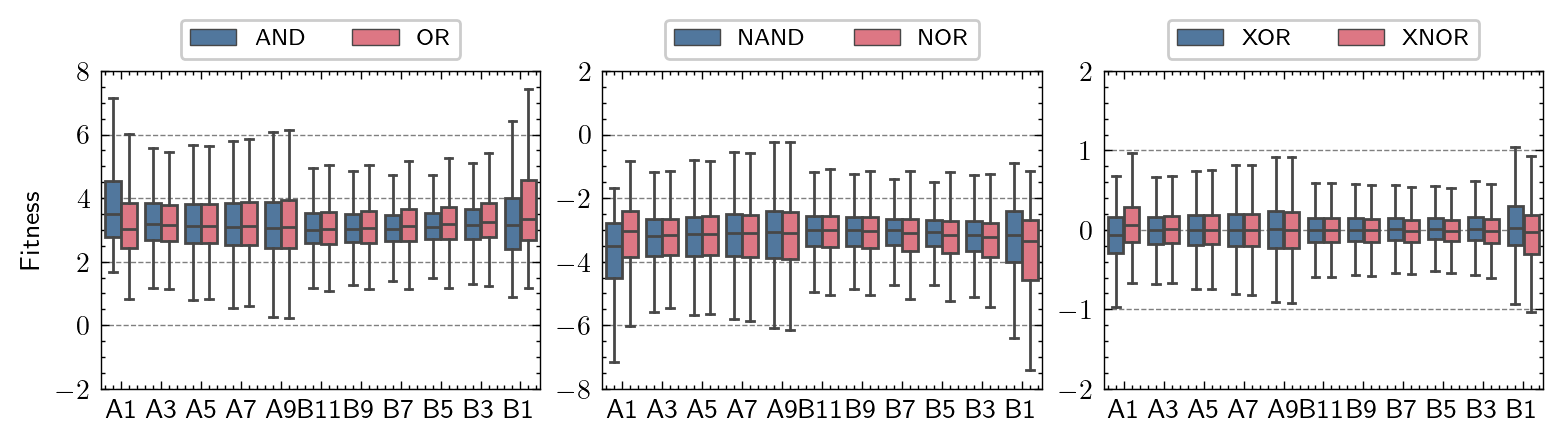

In [5]:
with plt.style.context(["science","bright", "grid"]):
    
    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2.2)
    fig.set_figheight(fig.get_figheight()*0.8)

    ax  = fig.add_subplot(1,3,1)
    ax  = sns.boxplot(fitness_res[(fitness_res['Gate']=='AND Fitness') | (fitness_res['Gate']=='OR Fitness')], x='key', y='Fitness', hue='Gate', ax=ax, fliersize=0)
    ax.set_ylim(-2,8)
    ax.set_ylabel("Fitness")
    ax.set_xlabel("")
    l = ax.legend(title='', bbox_to_anchor=(0.5,1.1), loc='center', fontsize='small', ncol=2)
    l.get_texts()[0].set_text('AND')
    l.get_texts()[1].set_text('OR')

    ax  = fig.add_subplot(1,3,2)
    ax  = sns.boxplot(fitness_res[(fitness_res['Gate']=='NAND Fitness') | (fitness_res['Gate']=='NOR Fitness')], x='key', y='Fitness', hue='Gate', ax=ax, fliersize=0)
    ax.set_ylim(-8,2)
    ax.set_ylabel("")
    ax.set_xlabel("")
    l = ax.legend(title='', bbox_to_anchor=(0.5,1.1), loc='center', fontsize='small', ncol=2)
    l.get_texts()[0].set_text('NAND')
    l.get_texts()[1].set_text('NOR')

    ax  = fig.add_subplot(1,3,3)
    ax  = sns.boxplot(fitness_res[(fitness_res['Gate']=='XOR Fitness') | (fitness_res['Gate']=='XNOR Fitness')], x='key', y='Fitness', hue='Gate', ax=ax, fliersize=0)
    ax.set_ylim(-2,2)
    ax.set_ylabel("")
    ax.set_xlabel("")
    l = ax.legend(title='', bbox_to_anchor=(0.5,1.1), loc='center', fontsize='small', ncol=2)
    l.get_texts()[0].set_text('XOR')
    l.get_texts()[1].set_text('XNOR')

fig.savefig("plots/box_plots.svg", transparent=True)

## Nonlinear Parameter

In [6]:
x_vals  = [f"A{i-3}" for i in N_valsA] + [f"B{i-3}" for i in N_valsB[::-1]]

# Current Relations
paramsA = {N : nonlinear_parameter(dataA[N], input1_column='E0', input2_column='E1') for i, N in enumerate(N_valsA)}
paramsB = {N : nonlinear_parameter(dataB[N], input1_column='E0', input2_column='E1') for i, N in enumerate(N_valsB)}

# NDR
Q_ndr_l = np.array([return_ndr(paramsA[N]['Ml']) for N in N_valsA])
Q_ndr_r = np.array([return_ndr(paramsA[N]['Mr']) for N in N_valsA])
Q_ndrA  = (Q_ndr_l + Q_ndr_r) / 2

# NDR
Q_ndr_l = np.array([return_ndr(paramsB[N]['Ml']) for N in N_valsB])
Q_ndr_r = np.array([return_ndr(paramsB[N]['Mr']) for N in N_valsB])
Q_ndrB  = (Q_ndr_l + Q_ndr_r) / 2
Q_ndr   = np.append(Q_ndrA, Q_ndrB[::-1])

# NLS
bins    = 100
Q_nlsA  = np.array([return_nls(df=paramsA[N], bins=bins) for N in N_valsA])
Q_nlsB  = np.array([return_nls(df=paramsB[N], bins=bins) for N in N_valsB])
Q_nls   = np.append(Q_nlsA, Q_nlsB[::-1])

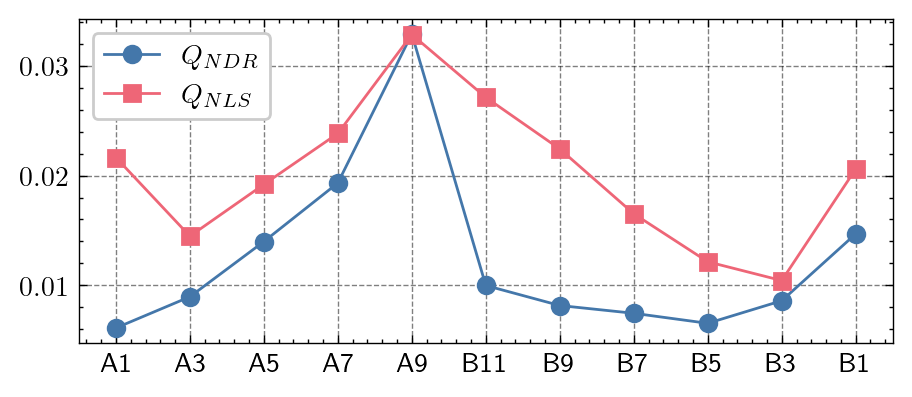

In [7]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    fig.set_figwidth(fig.get_figwidth()*1.5)
    fig.set_figheight(fig.get_figheight()*0.8)
    ax  = fig.add_subplot()
    ax.plot(x_vals, Q_ndr, '-o', label='$Q_{NDR}$')
    ax.plot(x_vals, Q_nls, '-s', label='$Q_{NLS}$')
    ax.legend(loc='upper left')
fig.savefig("plots/nonlinear_params.svg", transparent=True)

---

## Relative Error

In [8]:
# max_jumps_portionA   = [100*((dataA[N]['Jumps']==1e7).sum() / len(dataA[N])) for N in N_valsA]
# rel_error_distA      = [100*np.abs(dataA[N]['Error'].values / dataA[N]['Observable'].values) for N in N_valsA]

# max_jumps_portionB   = [100*((dataB[N]['Jumps']==1e7).sum() / len(dataB[N])) for N in N_valsB]
# rel_error_distB      = [100*np.abs(dataB[N]['Error'].values / dataB[N]['Observable'].values) for N in N_valsB]

In [9]:
# def lin_func(x, a, b):
#     return a*x + b
# def log_func(x, a, b):
#     return a * np.log(x) + b

# with plt.style.context(["science","bright","grid"]):

#     cmap    = plt.get_cmap('Reds')
#     fig     = plt.figure(dpi=200, layout='constrained')
#     ax1     = fig.add_subplot(1,2,1)
#     ax2     = fig.add_subplot(1,2,2)
#     fig.set_figwidth(fig.get_figwidth()*1.5)
#     fig.set_figheight(fig.get_figheight()*0.8)

#     for i, arr in enumerate(rel_error_distA[::-1]):
#         arr1            = arr.copy()
#         arr1[arr1 > 10] = 10
#         ax1             = sns.kdeplot(arr1, ax=ax1, color=cmap((len(rel_error_distA)-i)/len(rel_error_distA)), 
#                                       fill=True, alpha=0.1, log_scale=True)

#     ax1.set_xlim(5,12)
#     ax1.set_xlabel('$u_I / I$ [\%]')

#     x       = np.array(N_valsA)
#     y       = max_jumps_portion
#     p, _    = curve_fit(lin_func, x, y)
#     ax2.plot(x, y, 'o')
#     ax2.plot(x, lin_func(x,*p), '-')
#     ax2.set_xlabel('$N_{NP}$')
#     ax2.set_ylabel('$P[N_{j} > N_{j,max}]$ [\%]')
#     # ax2.set_xlim(0,270)

#     # fig.savefig("../plots/data_quality_vs_system_size.svg", transparent=True, bbox_inches='tight')
#     # fig.savefig("../plots/data_quality_vs_system_size.pdf", transparent=False, bbox_inches='tight')